In [1]:
import numpy as np
import pandas as pd

**MLP from Scratch**

In [2]:
class MLP:
    def __init__(self,learning_rate=0.01,inputsize=3,hiddensize=2,outputsize=2):
        self.inputsize=inputsize
        self.hiddensize=hiddensize
        self.outputsize=outputsize
        self.learningrate=learning_rate
        self.inputweights=np.random.randn(inputsize,hiddensize)
        self.hiddenweigths=np.random.randn(hiddensize,outputsize)
        self.hiddenbias=np.zeros(hiddensize)
        self.outputbias=np.zeros(outputsize)
    
    def activation(self,x,type):
        if type=='sigmoid':
            return 1/(1+np.exp(-x))
        elif type=='linear':
            return x
    
    def activation_derivative(self,x,type):
        if type=='sigmoid':
            return x*(1-x)
        elif type=='linear':
            return 1
        
    def forward(self,input):
        self.input=input
        hidden_ouput=np.dot(input,self.inputweights)+self.hiddenbias
        self.hidden_output=self.activation(hidden_ouput,'linear')
        final_output=np.dot(self.hidden_output,self.hiddenweigths)+self.outputbias
        self.final_output=self.activation(final_output,'sigmoid')

    def backward(self,expected):
        error=expected-self.final_output
        output_delta=error*self.activation_derivative(self.final_output,'sigmoid')
        self.hiddenweigths=self.hiddenweigths+self.learningrate*np.dot(self.hidden_output.reshape(-1,1),output_delta.reshape(1,-1))
        hidden_delta=np.dot(output_delta*self.activation_derivative(self.hidden_output,'linear'),self.hiddenweigths.T)
        self.inputweights = self.inputweights + self.learningrate * np.dot(self.input.values.reshape(1, -1).T, hidden_delta.reshape(1, -1))
        self.hiddenbias=self.hiddenbias+self.learningrate*hidden_delta
        self.outputbias=self.outputbias+self.learningrate*output_delta

    def train(self,input,output,epochs=100):
        for _ in range(epochs):
            for i in range(input.shape[0]):
                self.forward(input.iloc[i])
                temp = [0 for _ in range(self.outputsize)]
                temp[int(output.iloc[i].iloc[0])] = 1
                self.backward(temp)


    def predict(self,input):
        prediced=[]
        for i in range(len(input)):
            self.forward(input.iloc[i])
            prediced.append(np.argmax(self.final_output))
        return prediced
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    #for roc,auc
    def predict_proba(self, input):
        probas = []
        for i in range(len(input)):
            self.forward(input.iloc[i])
            probas.append(self.final_output)
        return self.softmax(np.array(probas))


**Loading and Preprocessing dataset**

In [3]:
dataset=pd.read_csv("Iris.csv")
dataset

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [4]:
dataset=dataset[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm','Species']]
dataset

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [5]:
x=dataset.iloc[:,:-1]
inputsize=x.shape[1]

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
dataset['Species_encoded']=encoder.fit_transform(dataset['Species'])
y=dataset[['Species_encoded']]
y.rename(columns={'Species_encoded':'Species'},inplace=True)
unique=encoder.classes_
outputsize=len(unique)
print(outputsize)


3


C:\Users\HP\AppData\Local\Temp\ipykernel_4860\841555332.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.rename(columns={'Species_encoded':'Species'},inplace=True)


In [7]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [8]:
mlp=MLP(learning_rate=0.01,inputsize=inputsize,hiddensize=5,outputsize=outputsize)
mlp.train(x_train,y_train)
predicted=mlp.predict(x_test)

**Evaluation from scratch**

In [9]:
def accuracy(actual,predicted):
    accurate=0
    for i in range(len(predicted)):
        if predicted[i]==actual.iloc[i].iloc[0]:
            accurate=accurate+1
    return accurate/len(predicted)

print('Accuracy:',accuracy(y_test,predicted)*100,'%')

def precision(actual,predicted):
    precision_individual=[]
    for i in range(outputsize):
        tp=0
        fp=0
        for j in range(len(predicted)):
            if (predicted[j]==i and actual.iloc[j].iloc[0]==i):
                tp=tp+1
            elif predicted[j]==i:
                fp=fp+1
            if tp+fp==0:
                temp=0
            else:
                temp=tp/(tp+fp)
        precision_individual.append(temp)
    return precision_individual

print('Precision:',precision(y_test,predicted))

def recall(actual,predicted):
    recall_individual=[]
    for i in range(outputsize):
        tp=0
        fn=0
        for j in range(len(predicted)):
            if (predicted[j]==i and actual.iloc[j].iloc[0]==i):
                tp=tp+1
            elif actual.iloc[j].iloc[0]==i:
                fn=fn+1
            if tp+fn==0:
                temp=0
            else:
                temp=tp/(tp+fn)
        recall_individual.append(temp)
    return recall_individual


print('Recall:',recall(y_test,predicted))

def f1_score(precision,recall):
    f1score=[]
    for i in range(outputsize):
        if precision[i]+recall[i]==0:
            f1score.append(0)
        else:
            f1score.append((2*precision[i]*recall[i])/(precision[i]+recall[i]))
    return f1score

print('f1-score:',f1_score(precision(y_test,predicted),recall(y_test,predicted)))
    

Accuracy: 100.0 %
Precision: [1.0, 1.0, 1.0]
Recall: [1.0, 1.0, 1.0]
f1-score: [1.0, 1.0, 1.0]


In [10]:
def confusionmatrix(actual,predicted):
    cm=[]
    for i in range(outputsize):
        temp=[]
        for j in range(outputsize):
            temp.append(sum([1 for k in range(len(predicted)) if predicted[k]==j and actual.iloc[k].iloc[0]==i]))
        cm.append(temp)
    return cm

print(confusionmatrix(y_test,predicted))

[[10, 0, 0], [0, 9, 0], [0, 0, 11]]


**Built in evlaution** *for comparison only*

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve,auc

print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


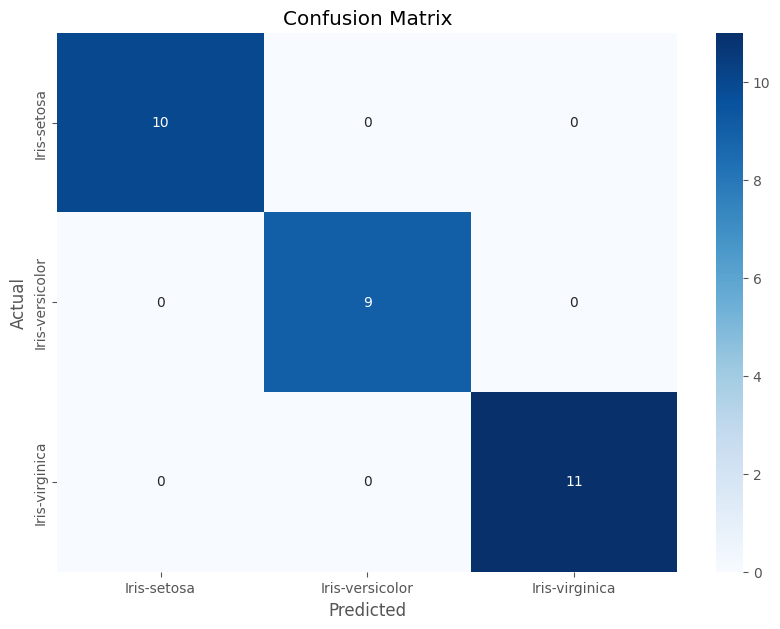

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,predicted)
print(cm)

plt.figure(figsize=(10,7))
sns.heatmap(cm,cmap="Blues",annot=True,fmt="d",xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()